# Exploring the Balloon Model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import features from TVB (...)

In [2]:
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold
from tvb.simulator.plot import timeseries_interactive as timeseries_interactive

Use default connectivity matrix 

In [3]:
conn = connectivity.Connectivity.from_file()

WARNING  File 'hemispheres' not found in ZIP.


Configure stimulus spatial pattern

In [4]:
weighting = numpy.zeros((76, ))
weighting[[0, 7, 13, 33, 42]] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

temporal profile

In [5]:
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 25000.0
eqn_t.parameters["sigma"] = 1.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=numpy.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500),
        monitors.ProgressLogger(period=5e3),
        ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0005 s
   INFO  step 10001 time 5.0005 s
   INFO  step 20001 time 10.0005 s
   INFO  step 30001 time 15.0005 s
   INFO  step 40001 time 20.0005 s
   INFO  step 50001 time 25.0005 s
   INFO  step 60001 time 30.0005 s
   INFO  step 70001 time 35.0005 s
   INFO  step 80001 time 40.0005 s
   INFO  step 90001 time 45.0005 s
   INFO  step 100001 time 50.0005 s
   INFO  step 110001 time 55.0005 s


Make the lists numpy.arrays for easier use

In [6]:
TAVG_TIME = numpy.array(tavg_time)
BOLD_TIME = numpy.array(bold_time)
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)

Create TimeSeries instance

In [7]:
tsr = TimeSeriesRegion(connectivity = conn,
                       data = TAVG,
                       time = TAVG_TIME,
                       sample_period = 2.)
tsr.configure()

Create and run the monitor/analyser

In [8]:
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Visualize the BOLD response

Text(0.5, 0, 'Time (ms)')

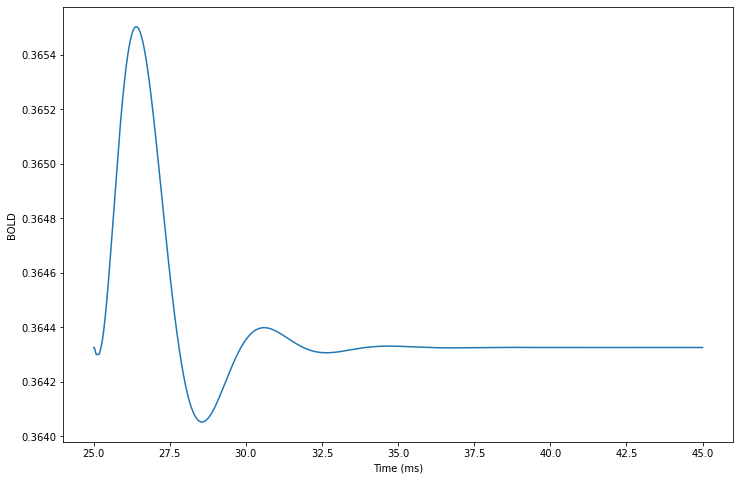

In [9]:
plt.figure(figsize=(12,8))

#plt.subplot(212)
plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0])
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

Some text (model hx/evolution)

### Friston 2000:
$$`G(t - t^{\prime}) =
             e^{\frac{1}{2} \left(\frac{t - t^{\prime}}{\tau_s} \right)}
             \frac{\sin\left((t - t^{\prime})
             \sqrt{\frac{1}{\tau_f} - \frac{1}{4 \tau_s^2}}\right)}
             {\sqrt{\frac{1}{\tau_f} - \frac{1}{4 \tau_s^2}}}
             \; \; \; \; \; \;  for \; \; \; t \geq t^{\prime}
             = 0 \; \; \; \; \; \;  for \; \; \;  t < t^{\prime}
$$

### Stephan 2007:

$$
\frac{ds}{dt} = x - \kappa\,s - \gamma \,(f-1) \\
\frac{df}{dt} = s \\
\frac{dv}{dt} = \frac{1}{\tau_o} \, (f - v^{1/\alpha})\\
\frac{dq}{dt} = \frac{1}{\tau_o}(f \, \frac{1-(1-E_0)^{1/\alpha}}{E_0} - v^{1/\alpha} \frac{q}{v})\\
\kappa = \frac{1}{\tau_s}\\
\gamma = \frac{1}{\tau_f}
$$

In [10]:
def balloon_dfun(self, state_variables, neural_input, local_coupling=0.0):
    s = state_variables[0, :]
    f = state_variables[1, :]
    v = state_variables[2, :]
    q = state_variables[3, :]

    x = neural_input[0, :]

    ds = x - (1. / self.tau_s) * s - (1. / self.tau_f) * (f - 1)
    df = s
    dv = (1. / self.tau_o) * (f - v ** (1. / self.alpha))
    dq = (1. / self.tau_o) * ((f * (1. - (1. - self.E0) ** (1. / f)) / self.E0) -
                              (v ** (1. / self.alpha)) * (q / v))

    return numpy.array([ds, df, dv, dq])

About the balloon_dfun model as is

In [11]:
def mod_balloon_dfun(self, state_variables, neural_input, local_coupling=0.0):
    s = state_variables[0, :]
    f = state_variables[1, :]
    v = state_variables[2, :]
    q = state_variables[3, :]

    x = neural_input[0, :]

    ds = x - (1. / self.tau_s) * s - (1. / self.tau_f) * (f - 1)
    df = s
    dv = (1. / self.tau_o*0.5) * (f - v ** (1. / self.alpha))
    dq = (1. / self.tau_o*0.5) * ((f * (1. - (1. - self.E0) ** (1. / f)) / self.E0) -
                              (v ** (1. / self.alpha)) * (q / v))

    return numpy.array([ds, df, dv, dq])

Overwrite/ride dfun

In [12]:
bold.BalloonModel.balloon_dfun = mod_balloon_dfun

parameter modification

In [13]:
def set_params(self,tau_s=1.54,tau_f=1.44,tau_o=0.98,alpha=0.32,E0=0.4):
    bold.BalloonModel.tau_s = tau_s,
    bold.BalloonModel.tau_f = tau_f,
    bold.BalloonModel.tau_o = tau_o,
    bold.BalloonModel.alpha = alpha,
    bold.BalloonModel.E0 = E0

Create and run the monitor/analyser

In [14]:
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Friston 2000 Fig. 8

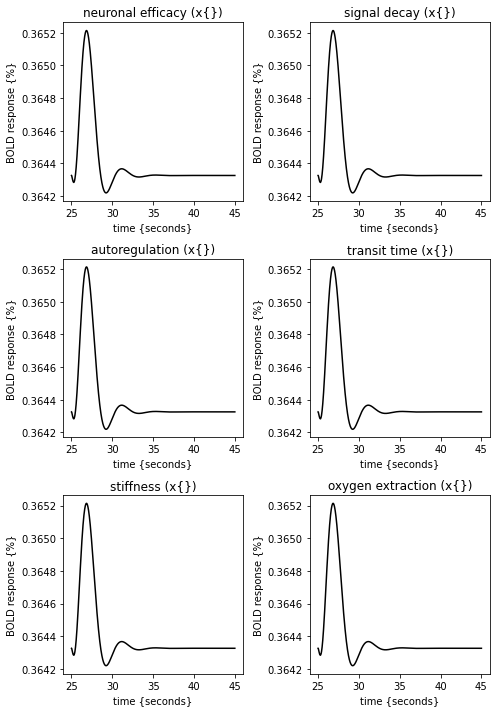

In [15]:
titles=['neuronal efficacy (x{})',
        'signal decay (x{})',
        'autoregulation (x{})',
        'transit time (x{})',
        'stiffness (x{})',
        'oxygen extraction (x{})']

fig, ax = plt.subplots(ncols=2,nrows=3, figsize=(7,10))

a=ax[0,0];a.set_title(titles[0])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

a=ax[0,1];a.set_title(titles[1])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

a=ax[1,0];a.set_title(titles[2])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

a=ax[1,1];a.set_title(titles[3])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

a=ax[2,0];a.set_title(titles[4])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

a=ax[2,1];a.set_title(titles[5])
a.set_xlabel('time {seconds}');a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0], c='k')

plt.tight_layout()
plt.show()

In [16]:
a=ax[0,1];a.set_title(titles[0])
a.set_xlabel('time {seconds}')
a.set_ylabel('BOLD response {%}')
a.plot(bold_data.time[25000:45000], 
       bold_data.data[25000:45000, 0, [42], 0], 
       c='k')

In [17]:
plt.show()

`tau_s` - kappa => doubling rate of signal decay leads to lesser response maximum and reduced undershoot  'rate constant of the vasodilatory signal decay'

`tau_f` - gamma => doubling leads to half value, similar shape in terms of range but more pronounced overshoot & rebound 'rate constant for autoregulatory feedback by blood flow'

`tau_o` - tau => mean transit time of blood, avg time blood takes to traverse venous compartment, corresponds to ratio of resting blood volume V_0 to resting blood floow F_0: V_0/F_0 'transit time'
=> * 0.5 => big change, less undershoot - what other parameter change is this similar to? why?

`alpha` - 'Stiffness parameter. Grubb's exponent.', could replace w Buxton's formulation but less generalisability (footnote 3 Stephan2007) => increase -> nonlinear increase in BOLD response - 2x alpha => ~50% increase in BOLD response, 10x alpha ~ 100% increase in BOLD response

`E0` - increase -> BOLD decrease
drop EO (oxygen extraction fraction) by 10% -> ~ 10x BOLD response - makes sense, signal is due to diamagnetic property of oxyhemoglobin
increase E0 by 10% -> we get a negative valued BOLD response - doesn't make sense but a reduction would mean - more oxygen extracted -> more deoxyhemoglobin - less signal


neither (`alpha`, `E0`) have ~ any effect on response shape

streamplotS?

Example final plot (overlay) code

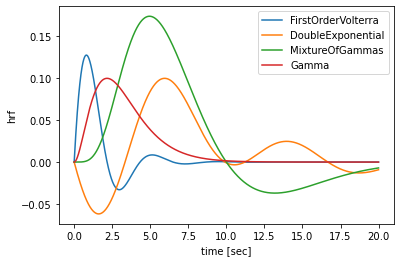

In [18]:
hrf_kernels = [equations.FirstOrderVolterra(),
               equations.DoubleExponential(),
               equations.MixtureOfGammas(),
               equations.Gamma()]

figure()
for hrf in hrf_kernels: 
    bold_monitor = monitors.Bold(hrf_kernel=hrf)
    bold_monitor.dt = 2**-4
    bold_monitor.compute_hrf()
    plot(bold_monitor._stock_time,
         bold_monitor.hemodynamic_response_function.T[::-1], 
         label=hrf.__class__.__name__);

ylabel('hrf');
xlabel('time [sec]')    
legend()